In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCudaDeepReadout import BasicESNCudaDeepReadout as BasicESN
    from reservoir.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from reservoir.ThreeHierarchyESNCuda import ThreeHierarchyESNCuda as ThreeHierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

X_train, y_train = data_preparation.get_raw_data('train')
X_val, y_val = data_preparation.get_raw_data('val')
X_test, y_test = data_preparation.get_raw_data('test')

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

class_weights = data_preparation.get_class_weights()

data_preprocessor = DataPreprocessor()

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - spectrogram_data(x, y, n_fft, stride, reshape)
# - spectrogram_predictions_to_samples(y_pred, n_samples, n_fft, stride)
# - pipeline(step_names, x, y)
# - get_available_steps()

# First, we will try a basicESN with the optimal hyperparameters found in the previous notebook along with the spectrogram_data preprocessing method

# The optimal hyperparameters were:
basic_n_neurons = 500
basic_density = 0.2
basic_leakage = 0.8
basic_spectral_radius = 0.999
basic_gamma = 0.999
basic_sparsity = 0.8
basic_input_weight_type = 'uniform'


In [7]:
run_basic_optimal = True

In [8]:
# Now we can try the best of each model and evaluate them on the test set
# We will use the best n_fft and stride values found for each model
basicESN_pickle = 'basicESN_har70_deepReadout.pkl'

# First, the basicESN

if run_basic_optimal or not os.path.exists(basicESN_pickle):

    input_weights = generate_input_weights(basic_n_neurons, X_train_scaled.shape[1], basic_density, basic_input_weight_type,
                                             seed=42)

    basic_esn = BasicESN(n_neurons=basic_n_neurons, leakage_rate=basic_leakage, spectral_radius=basic_spectral_radius,
                         gamma=basic_gamma,
                         sparsity=basic_sparsity, W_in=input_weights, class_weights=class_weights, seed=42)

    basic_esn.fit(X_train_scaled, y_train_encoded, x_val=X_val_scaled, y_val=y_val_encoded)

    with open(basicESN_pickle, 'wb') as f:
        pickle.dump(basic_esn, f)

else:
    with open(basicESN_pickle, 'rb') as f:
        basic_esn = pickle.load(f)

y_pred = basic_esn.forward(X_test_scaled)

# Bring the data back to the cpu
y_pred = y_pred.cpu().detach().numpy()

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using the spectrogram_data method, we need to convert the time frames back to samples


y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

print(f"BasicESN NMRSE: {nrmse}")

[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


  0%|          | 0/1357646 [00:00<?, ?it/s]E:\PyCharm\COM6906-Dissertation\model\reservoir\BasicESNCudaDeepReadout.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_cuda = torch.tensor(x, dtype=torch.float32, device='cuda')
100%|██████████| 1357646/1357646 [06:45<00:00, 3347.40it/s]
E:\PyCharm\COM6906-Dissertation\model\reservoir\BasicESNCudaDeepReadout.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device='cuda')


Shape of previous_states: torch.Size([1357646, 500])
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:43<00:00, 3278.31it/s]
E:\PyCharm\COM6906-Dissertation\model\reservoir\BasicESNCudaDeepReadout.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_state = torch.tensor(val_state, dtype=torch.float32, device='cuda')


Shape of previous_states: torch.Size([339404, 500])
Epoch 1/100, Loss: 1.9773553609848022
Epoch 2/100, Loss: 2.055171251296997
Epoch 3/100, Loss: 2.0730884075164795
Epoch 4/100, Loss: 1.9773553609848022
Epoch 5/100, Loss: 2.055171251296997
Epoch 6/100, Loss: 2.055171251296997
Epoch 7/100, Loss: 2.0546329021453857
Epoch 8/100, Loss: 1.882825493812561
Epoch 9/100, Loss: 1.8673145771026611
Epoch 10/100, Loss: 1.8665192127227783
Epoch 11/100, Loss: 1.8865125179290771
Epoch 12/100, Loss: 1.8852555751800537
Epoch 13/100, Loss: 1.8849066495895386
Epoch 14/100, Loss: 1.885313630104065
Epoch 15/100, Loss: 1.8853144645690918
Epoch 16/100, Loss: 1.8760945796966553
Epoch 17/100, Loss: 1.867117166519165
Epoch 18/100, Loss: 1.9773547649383545
Epoch 19/100, Loss: 1.8667147159576416
Epoch 20/100, Loss: 1.8643131256103516
Epoch 21/100, Loss: 1.9759070873260498
Epoch 22/100, Loss: 1.8508769273757935
Epoch 23/100, Loss: 1.8588340282440186
Epoch 24/100, Loss: 1.8772705793380737
Epoch 25/100, Loss: 1.73550

100%|██████████| 562547/562547 [02:50<00:00, 3305.00it/s]


Shape of previous_states: torch.Size([562547, 500])
BasicESN NMRSE: 0.5713515568002756


In [9]:
# Create a classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_decoded, y_pred_decoded))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.28      0.99      0.44    141796
           7       0.66      1.00      0.79     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.33    562547
   macro avg       0.13      0.28      0.18    562547
weighted avg       0.12      0.33      0.17    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


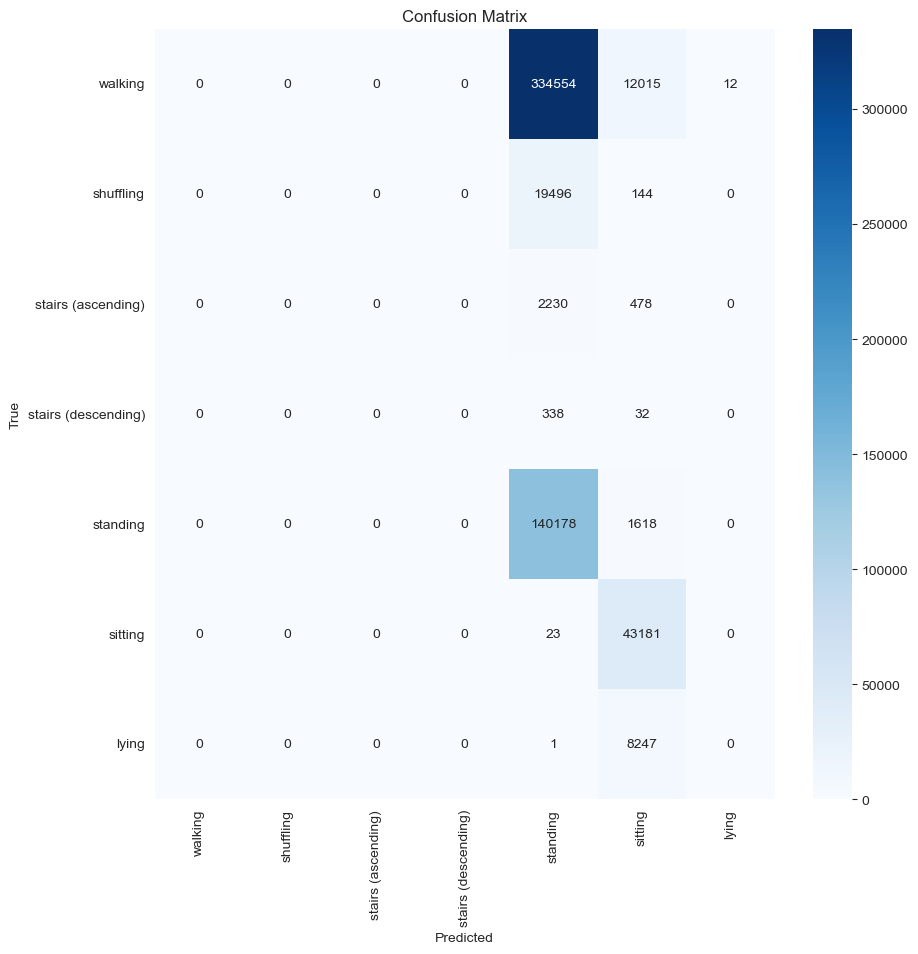

In [10]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

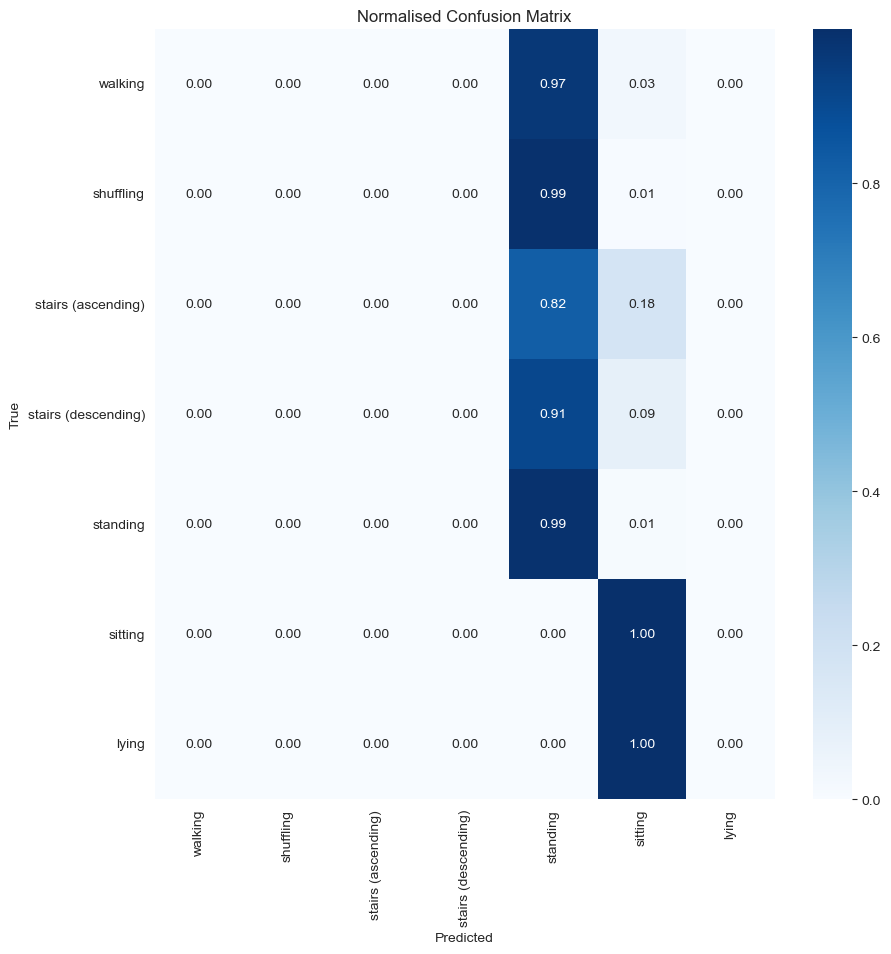

In [11]:
# Now a normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()